# Plots and exploration
This notebook contains plots and other code to explore the edge-consistency and neighbor-consistency metrics, and compare them with other metrics.

Example data taken from: [Gibler, Douglas M. 2009. International military alliances, 1648-2008. CQ Press.  ](http://www.correlatesofwar.org/data-sets/formal-alliances)

## Imports and data loading

In [1]:
# Imports
%matplotlib inline
import matplotlib
import os
import pandas as pd
import leidenalg 
import igraph as ig

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import nwtools.common, nwtools.consensus, nwtools.communities
import scipy.stats

In [2]:
datapath = '../data'

In [3]:
consensus_matrix = np.load(os.path.join(datapath, 'consensus.npy'))
edges_att_df = pd.read_csv(os.path.join(datapath, 'edges-consistency.csv'), na_filter=False)

nodes_att_df = pd.read_csv(os.path.join(datapath, 'nodes-consistency.csv'), index_col=0,
                          na_values=[''], keep_default_na=False)

partitions_df = pd.read_csv(os.path.join(datapath, 'partitions.csv'), na_filter=False)
graph = ig.Graph.Read_Pickle(os.path.join(datapath, 'graph.pkl'))

initial_partition = [leidenalg.ModularityVertexPartition(graph, initial_membership=row.values, weights='weight') 
 for i,row in partitions_df.iterrows()]

## Consensus clustering and edge-consistency

We plot the consensus matrix, where the consensus value for a node combination is depicted through a grey value. We order the nodes based on their consensens clustering.

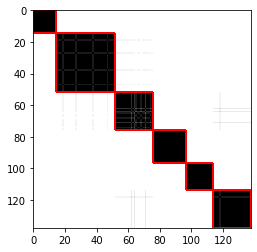

In [4]:
# plot the consensus matrix
consensus_membership = [nodes_att_df.loc[n, 'consensus'] for n in graph.vs['name']]
nwtools.communities.plot_sorted_adjacency(consensus_matrix, consensus_membership)

In [5]:
def density_scatter(x, y, ax=None, log=False):
    xy = np.vstack([x,y])
    dist = scipy.stats.gaussian_kde(xy)
    if ax is None:
        ax = plt.gca()
    if log:
        ax.scatter(x, y, c=np.log(dist(xy)))
    else:
        ax.scatter(x, y, c=dist(xy))
    return ax

Plot edge weight vs edge-consistency, colored by density

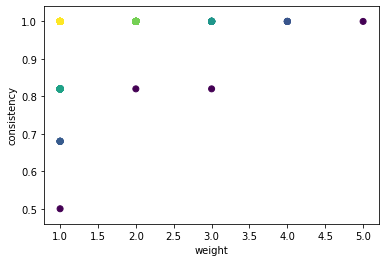

In [6]:
ax = density_scatter(edges_att_df['weight'], edges_att_df['consistency'], log=True)
#ax.set_xscale('log')
plt.xlabel('weight')
plt.ylabel('consistency')
plt.show()

Caclulate Spearman rank correlation between edgeweight and edge-consistency

In [7]:
corr, p = scipy.stats.spearmanr(edges_att_df['weight'], edges_att_df['consistency'])
print('rho={:.2f}, p={:.1E}'.format(corr, p))

rho=0.10, p=4.5E-04


## Node attributes (consistency, reference-consistency, contribution)

Here we calculate some alternative metrics: The reference consistency is based on consistency compared to the final community assignment. Penalty, contribution and gain are from:
de Santiago, Rafael, and Luís C. Lamb. "On the role of degree influence in suboptimal modularity maximization." 2016 IEEE Congress on Evolutionary Computation (CEC). IEEE, 2016.

In [8]:
def reference_consistency(reference_membership, consensus_mat, graph):
    reference_part = ig.clustering.VertexClustering(graph, reference_membership)
    ref_mat = nwtools.consensus.get_consensus_matrix([reference_part], graph.vcount())
    reference_dif_mat = ref_mat - consensus_mat
    
    edge_indices = [e.tuple for e in graph.es]
    ix, jx = zip(*edge_indices)
    
    reference_dif = reference_dif_mat[ix, jx]
    reference_consistency = 1 - np.abs(np.array(reference_dif))
    
    # For nodes: look at avg consensus within cluster
    consensus_within_cluster = ref_mat*consensus_mat
    np.fill_diagonal(consensus_within_cluster, 0)
    node_consistency_within_cluster = np.sum(consensus_within_cluster, axis=0) / np.sum(consensus_within_cluster>0, axis=0) 
    return reference_dif, reference_consistency, node_consistency_within_cluster

In [9]:
ref_dif, ref_consistency, node_ref_consistency = reference_consistency(consensus_membership, 
                                                                                   consensus_matrix, graph)
nodes_att_df['node_ref_consistency'] = pd.Series(node_ref_consistency, index=graph.vs['name'])

In [10]:
gain, penalty, contribution = nwtools.consensus.modularity_contribution(graph, consensus_membership, weight='weight')
nodes_att_df['gain'] = gain
nodes_att_df['penalty'] = penalty
nodes_att_df['contribution'] = contribution

In [11]:
nodes_att_df.head()

,degree,weighted_degree,eigenvector_centrality,betweenness,consistency_mean,consistency_min,consistency_max,consistency_std,consistency_mean_min_std,consistency_neighbors_0.8,...,consistency_neighbors_1.0,ccode,name,latitude,longitude,consensus,node_ref_consistency,gain,penalty,contribution
SIE,14,14.0,0.001531,0.000000,1.000000,1.00,1.0,0.000000,1.000000,1.0,...,1.000000,451,Sierra Leone,8.640035,-11.840027,0,1.000000,0.008827,-0.000573,0.009401
BRA,33,33.0,0.936095,0.000000,0.994545,0.82,1.0,0.030856,0.963690,1.0,...,0.969697,140,Brazil,-10.333333,-53.200000,1,0.990000,0.020807,-0.008045,0.028852
FRN,21,29.0,0.118822,1939.289867,0.991429,0.82,1.0,0.038333,0.953096,1.0,...,0.952381,220,France,46.603354,1.888334,2,0.967391,0.015132,-0.002378,0.017510
LBR,15,16.0,0.030829,1722.000000,1.000000,1.00,1.0,0.000000,1.000000,1.0,...,1.000000,450,Liberia,5.749972,-9.365852,0,1.000000,0.009458,-0.000652,0.010110
BAR,33,39.0,0.936095,0.000000,0.994545,0.82,1.0,0.030856,0.963690,1.0,...,0.969697,53,Barbados,13.150033,-59.525031,1,0.990000,0.024590,-0.009485,0.034075


## Look at relationships between attributes

For the neighbor-consistency, as well as a few other node-level attributes, we plot the values compared to the weighted degree and calculate the Spearman rank correlation.

Correlation log-weighted degree and consistency_mean: rho=-0.29, p=5.5E-04


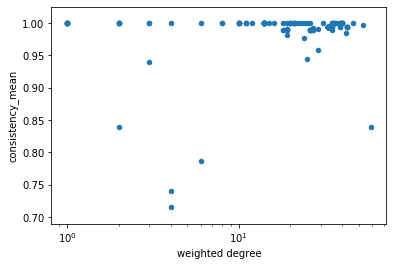

Correlation log-weighted degree and consistency_min: rho=-0.36, p=1.6E-05


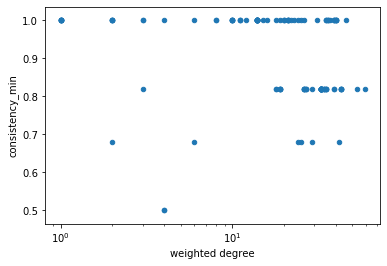

Correlation log-weighted degree and consistency_max: rho=0.11, p=2.1E-01


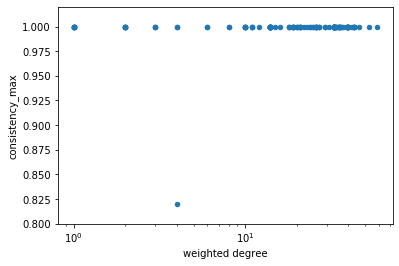

Correlation log-weighted degree and consistency_std: rho=0.29, p=7.0E-04


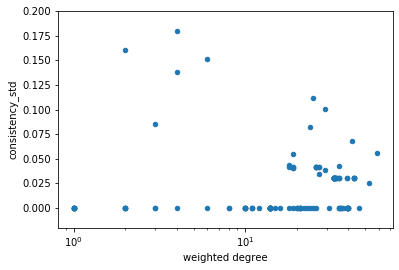

Correlation log-weighted degree and consistency_neighbors_0.8: rho=0.11, p=2.1E-01


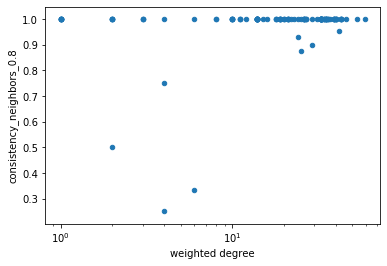

Correlation log-weighted degree and consistency_neighbors_0.9: rho=-0.29, p=6.3E-04


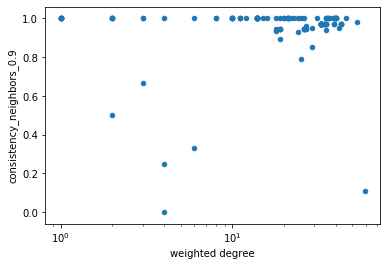

Correlation log-weighted degree and consistency_neighbors_1.0: rho=-0.29, p=6.3E-04


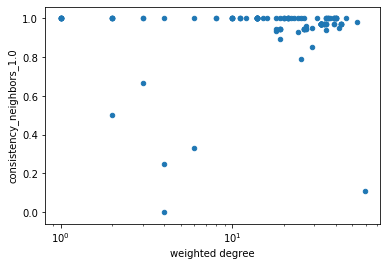

Correlation log-weighted degree and consistency_mean_min_std: rho=-0.29, p=5.5E-04


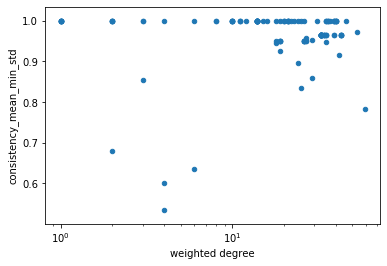

Correlation log-weighted degree and node_ref_consistency: rho=-0.01, p=9.3E-01


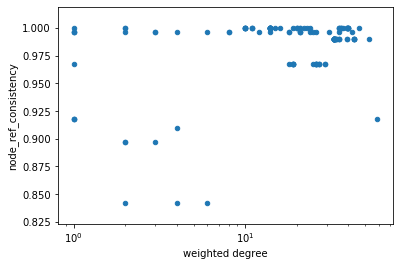

Correlation log-weighted degree and contribution: rho=0.97, p=2.4E-88


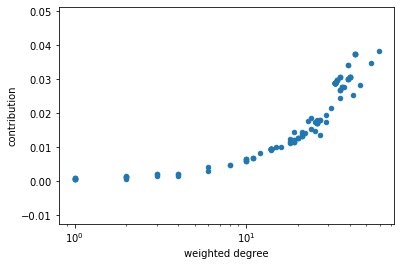

In [12]:
for attr in ['consistency_mean',
       'consistency_min', 'consistency_max', 'consistency_std',
       'consistency_neighbors_0.8', 'consistency_neighbors_0.9',
       'consistency_neighbors_1.0', 'consistency_mean_min_std',
            'node_ref_consistency', 'contribution']:
    corr = scipy.stats.spearmanr(np.log(nodes_att_df['weighted_degree']), nodes_att_df[attr])
    print('Correlation log-weighted degree and {}: rho={:.2f}, p={:.1E}'.format(attr, *corr))
    nodes_att_df.plot('weighted_degree', attr, kind='scatter')
    #density_scatter(nodes_att_df['weighted_degree'], nodes_att_df[attr])
    plt.ylabel(attr)
    plt.xlabel('weighted degree')
    plt.xscale('log')
    plt.show()

## Look into specific nodes

We want to see what the nodes with particular low consistency are

In [13]:
att = 'consistency_neighbors_0.9'
low_consistency_nodes = nodes_att_df.sort_values(att).head(20)
low_consistency_nodes[['name', att]]

,name,consistency_neighbors_0.9
SLO,Slovakia,0.000000
USA,United States of America,0.107143
ROM,Romania,0.250000
BUL,Bulgaria,0.333333
ALB,Albania,0.500000
CRO,Croatia,0.666667
TUR,Turkey,0.791667
GRC,Greece,0.850000
CZR,Czech Republic,0.894737
BLR,Belarus,0.928571


To get more insight, we look into the edges of the lowest consistency node

In [14]:
c = low_consistency_nodes.index[0]
edges_att_df[(edges_att_df.Source==c) | (edges_att_df.Target==c)]

,Source,Target,consensus,consistency,weight,distance
569,CZR,SLO,0.09,0.82,1,1.0
1173,ROM,SLO,0.25,0.50,1,1.0
1209,SLO,UKR,0.91,0.82,1,1.0
1210,SLO,UZB,0.91,0.82,1,1.0


## Consistency distribution

What is the distribution of the node consistency scores?
First look at the overall distribution, and then per community

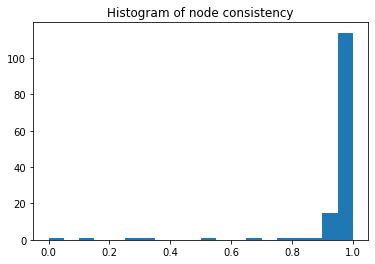

In [15]:
att = 'consistency_neighbors_0.9'
plt.hist(nodes_att_df[att], bins=np.arange(0,1.05,.05))
plt.title('Histogram of node consistency')
plt.show()

Community 0, size 15
Liberia, Guinea, Sierra Leone, Guinea-Bissau, Nigeria, Benin, Togo, Ivory Coast, Gambia, Mali, ..


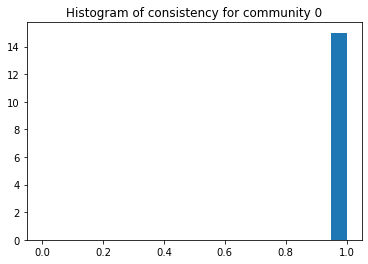


Community 1, size 37
United States of America, Canada, St. Vincent and the Grenadines, Antigua & Barbuda, St. Kitts and Nevis, St. Lucia, Dominica, Grenada, Barbados, Chile, ..


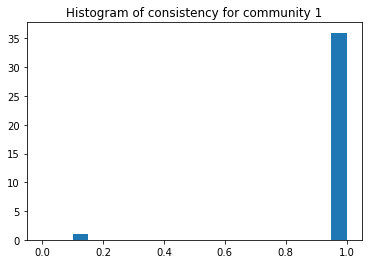


Community 2, size 24
France, Greece, Poland, United Kingdom, Portugal, Italy, Belgium, Spain, Luxembourg, Netherlands, ..


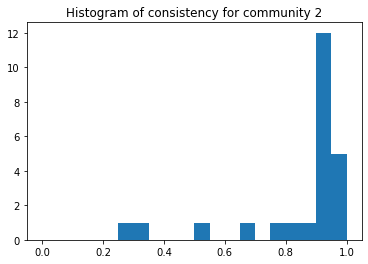


Community 3, size 21
Sudan, Bahrain, Kuwait, Saudi Arabia, Qatar, United Arab Emirates, Libya, Morocco, Algeria, Tunisia, ..


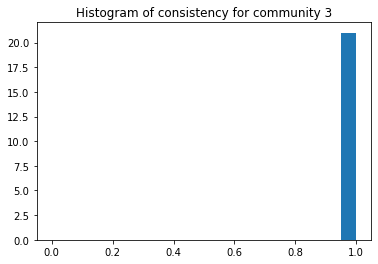


Community 4, size 17
Congo, Central African Republic, Democratic Republic of the Congo, Burundi, Angola, Rwanda, Kenya, Chad, Gabon, Sao Tome and Principe, ..


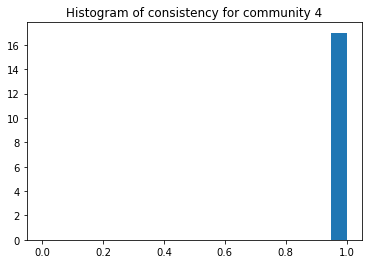


Community 5, size 24
Russia, Uzbekistan, Tajikistan, Kyrgyzstan, Kazakhstan, Belarus, Azerbaijan, Georgia, Armenia, Ukraine, ..


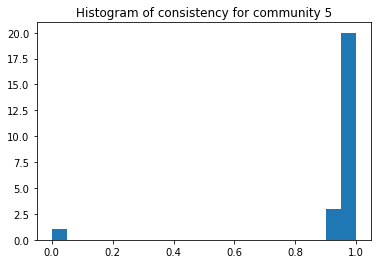

In [16]:
community_labels = nodes_att_df.consensus.unique()
for c in community_labels:
    nodes_sub = nodes_att_df[nodes_att_df['consensus']==c]
    print('Community {}, size {}'.format(c, len(nodes_sub)))
    heaviest_countries = list(nodes_sub.sort_values('weighted_degree', ascending=False).head(10)['name'])
    if len(nodes_sub)>10:
        heaviest_countries += ['..']
    print(', '.join(heaviest_countries))
    plt.hist(nodes_sub[att], bins=np.arange(0,1.05,.05))
    plt.title('Histogram of consistency for community {}'.format(c))
    plt.show()
    print()

# Plot the communities

Make a geographic plot of the nodes, where the color of the node depicts it community, and the intensity is based on the consistency

In [17]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [18]:
def plot_communities_map(long, lat, com_colors, ax, s=30):
    m = Basemap(projection='cyl',llcrnrlat=-80,urcrnrlat=80,\
        llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
    m.drawcoastlines(ax=ax, color='grey')
    m.drawcountries(ax=ax, color='grey')

    # Draw the country points
    x, y = m(long, lat)
    p = m.scatter(x,y,color=com_colors, ax=ax, norm=norm, s=s)

In [19]:
community_labels = nodes_att_df.consensus.unique()
ncom = len(community_labels)
cmap = plt.cm.get_cmap('tab20')
norm = matplotlib.colors.BoundaryNorm(np.arange(0, ncom+1), ncom)
color_dict = {c: cmap(i/ncom) for (i,c) in enumerate(community_labels)}

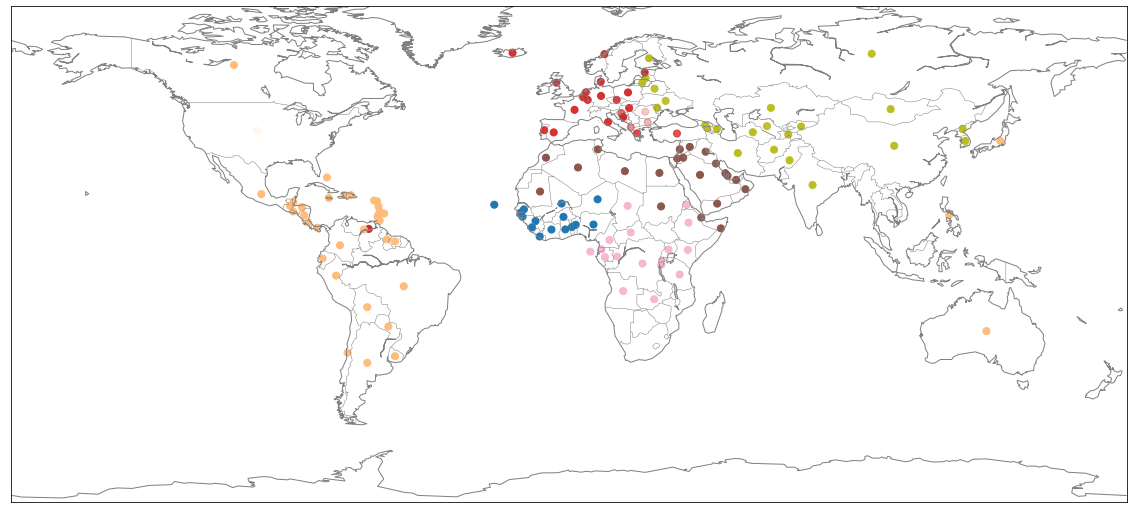

In [20]:
intensity_col='consistency_neighbors_0.9'
att = 'consensus'
com_colors = [color_dict[row[att]][:-1] + (row[intensity_col],) for i,row in nodes_att_df.iterrows()]

fig = plt.figure(figsize=(20, 15))
ax = plt.gca()
plot_communities_map(nodes_att_df['longitude'].values, nodes_att_df['latitude'].values, 
                     com_colors, ax, s=50)

Seperate plots for each community

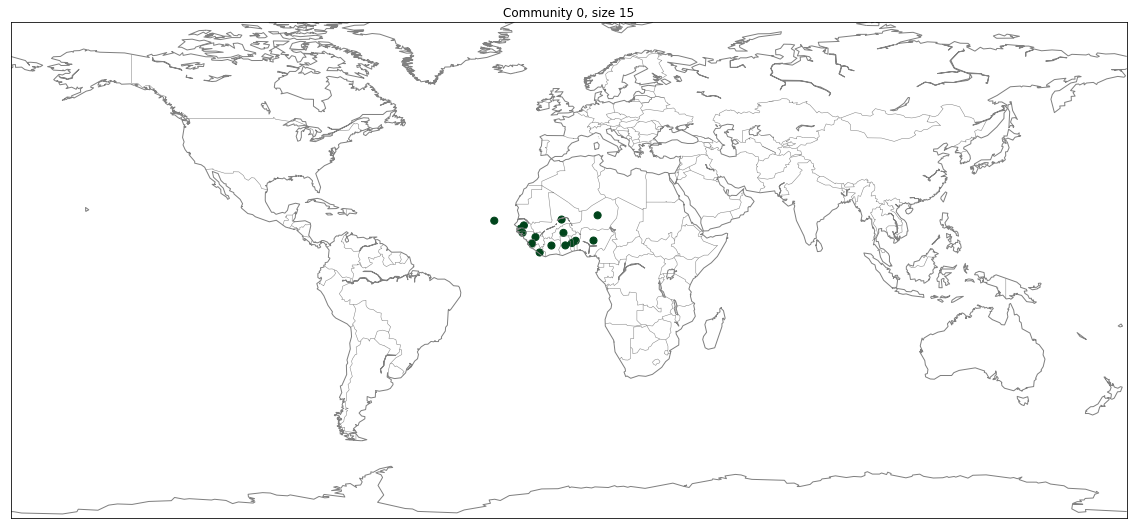

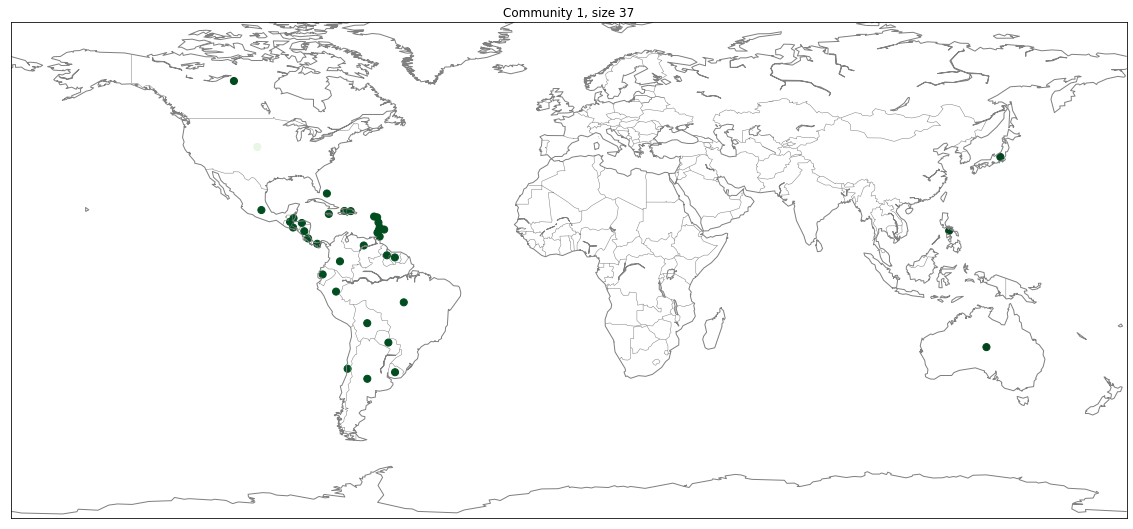

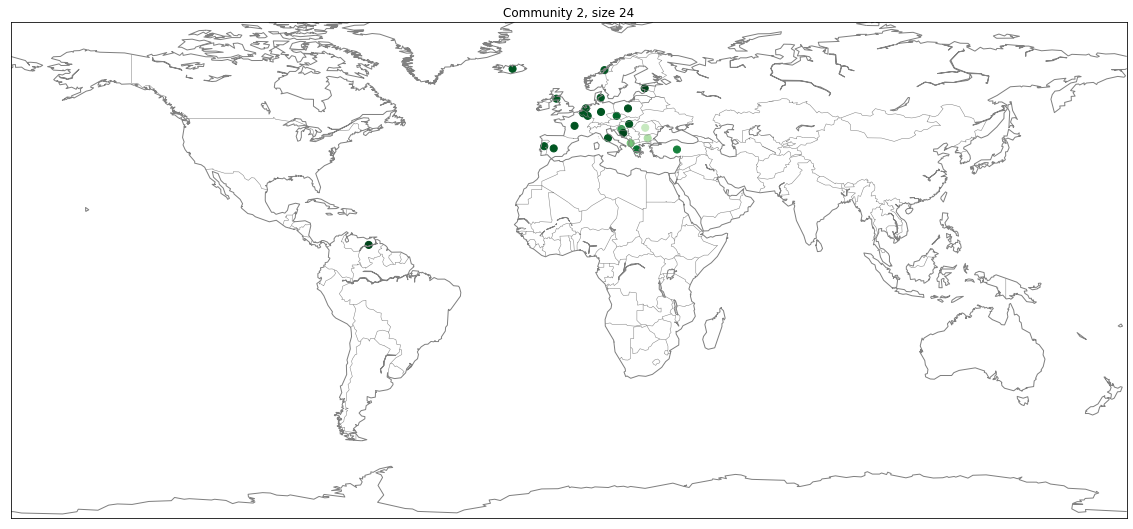

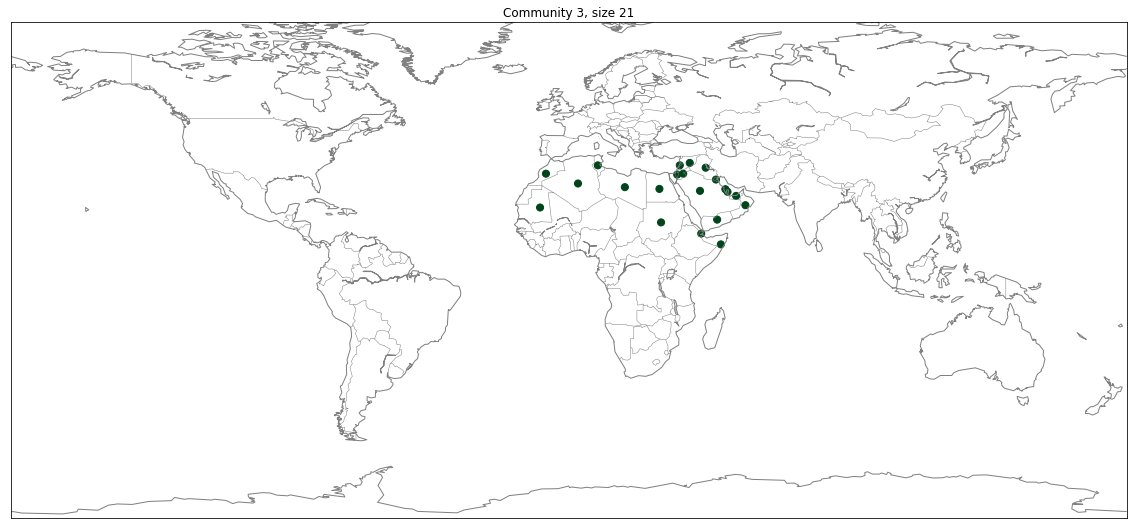

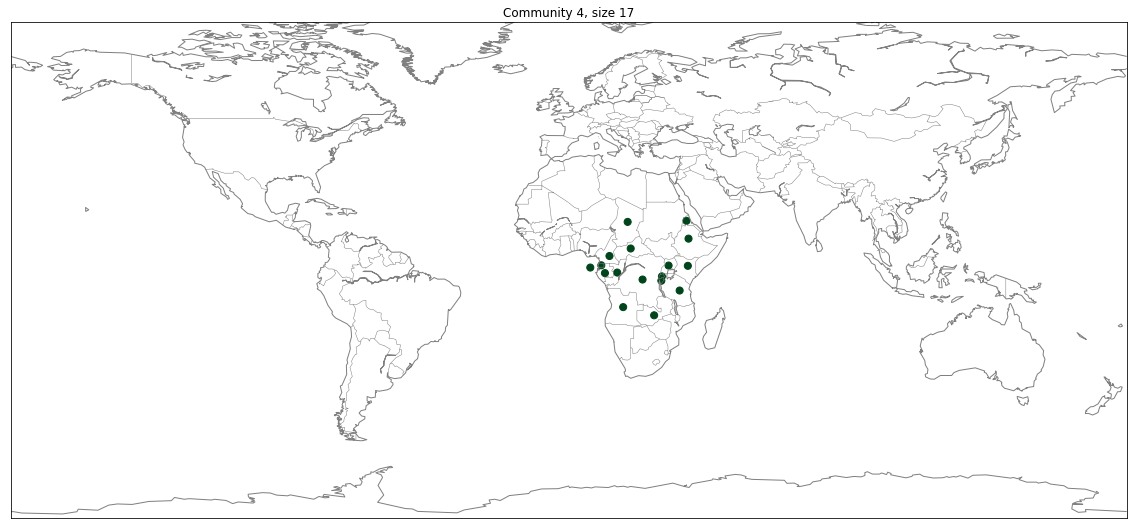

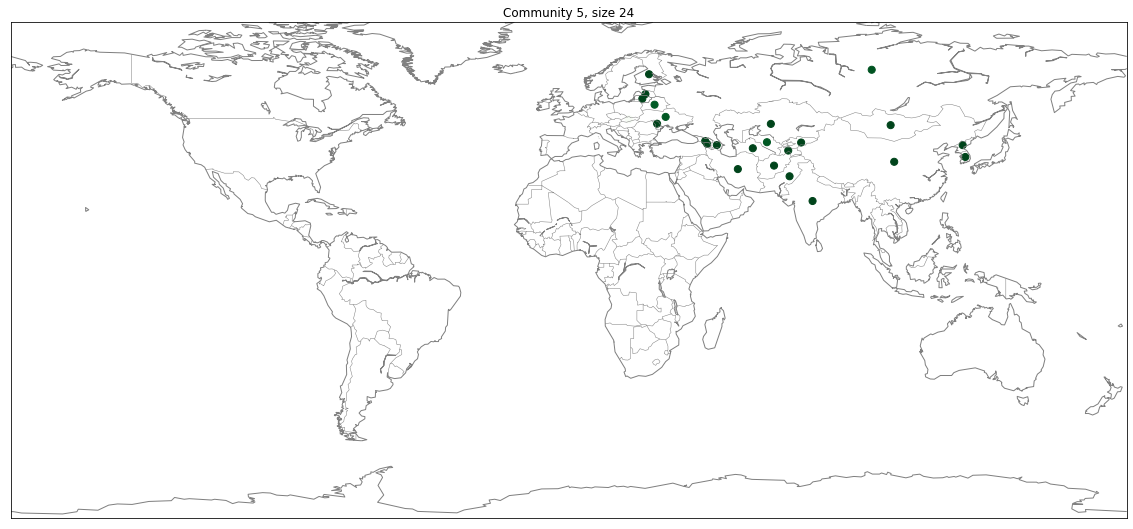

In [21]:
intensity_col='consistency_neighbors_0.9'
att = 'consensus'

for c in community_labels:
    nodes_sub = nodes_att_df[nodes_att_df[att]==c]
    #com_colors = [color_dict[row[att]][:-1] + (row[intensity_col],) for i,row in nodes_sub.iterrows()]
    com_colors = [plt.cm.get_cmap('Greens')(x) for x in nodes_sub[intensity_col]]
    fig = plt.figure(figsize=(20, 15))
    ax = plt.gca()
    plot_communities_map(nodes_sub['longitude'].values, nodes_sub['latitude'].values, 
                         com_colors, ax, s=50)
    plt.title('Community {}, size {}'.format(c, len(nodes_sub)))
    plt.show()

## Modularity landscape and partitionings

To get insight into the modularity landscape, and how the different partitions differ from each other and the consensus clustering, we look at Normalized Mutual Information scores and modularity values.

In [22]:
nmi_all, unique_partitions, unique_part_counts = nwtools.consensus.get_unique_partitions(initial_partition)

In [23]:
print('Nr of unique partitions:', len(unique_partitions))

Nr of unique partitions: 5


In [24]:
memberships = [p.membership for p in initial_partition]
modularities = [leidenalg.ModularityVertexPartition(graph, initial_membership=m, 
                                                 weights='weight').quality() for m in memberships]
new_ind = np.argsort(modularities) #np.argsort(ccs.membership)
nmi_all_rearranged = pd.DataFrame(nmi_all).loc[new_ind.tolist(), new_ind.tolist()].values

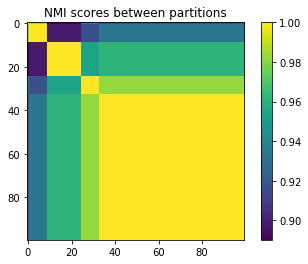

In [25]:
plt.imshow(nmi_all_rearranged)
plt.colorbar()
plt.title('NMI scores between partitions')
plt.show()

In [26]:
nmi_unique = nwtools.consensus.get_nmi_matrix([p.membership for p in unique_partitions])

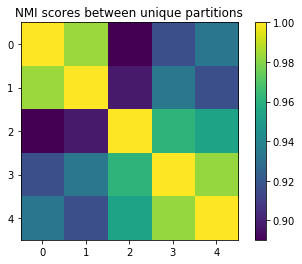

In [27]:
plt.imshow(nmi_unique)
plt.colorbar()
plt.title('NMI scores between unique partitions')
plt.show()

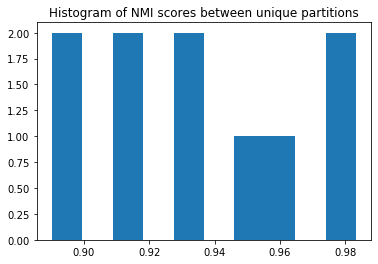

In [28]:
nmi_values = nmi_unique[np.triu_indices(nmi_unique.shape[0], 1)]
plt.hist(nmi_values)
plt.title('Histogram of NMI scores between unique partitions')
plt.show()

In [29]:
print('Average NMI: {:.3f}'.format(np.mean(nmi_values)))

Average NMI: 0.937


In [30]:
from sklearn.metrics.cluster import normalized_mutual_info_score
nmi_consensus = [normalized_mutual_info_score(consensus_membership, mem,
                                                  average_method='geometric')
                     for mem in memberships]
print('Average NMI between consensus clustering and initial partitions: {:.3f}'.format(np.mean(nmi_consensus)))

Average NMI between consensus clustering and initial partitions: 0.986


In [31]:
# How many communities do we have in each partition?
nr_communities = np.array([len(set(m)) for m in memberships])
for i,j in pd.Series(nr_communities).value_counts().iteritems():
    print('{} communities in {} partitions'.format(i,j))

6 communities in 91 partitions
7 communities in 9 partitions


We plot the modularity values of the initial partitions in sorted order. We also plot the modularity of the consensus clustering.

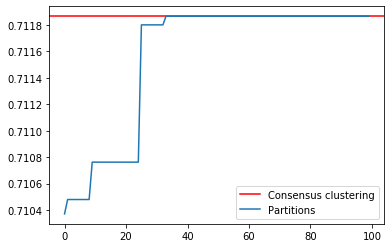

In [32]:
consensus_modularity = leidenalg.ModularityVertexPartition(graph, 
                                        initial_membership=consensus_membership,
                                                 weights='weight').quality()
x = sorted([p.quality() for p in initial_partition])

plt.axhline(y=consensus_modularity, c='red', label='Consensus clustering')
ax = plt.plot(x, label='Partitions')
plt.legend()
plt.show()

In [33]:
print('Mean modularity: {:.3f}'.format(np.mean(x)))

consensus_modularity = leidenalg.ModularityVertexPartition(graph, 
                                        initial_membership=consensus_membership,
                                                 weights='weight').quality()
print('Consensus modularity: {:.3f}'.format(consensus_modularity))

Mean modularity: 0.712
Consensus modularity: 0.712


## Consensus clustering thresholds

The script `consensus_clustering.py` runs consensus clustering for different thresholds, so we can inspect what is the best threshold.

In [34]:
df_cons_memberships = pd.read_csv(os.path.join(datapath, 'consensus_thresholds.csv'), index_col=0)
df_modularities = pd.read_csv(os.path.join(datapath, 'thresholds_modularity.csv'))
df_modularities

,threshold,modularity
0,0.0,0.711866
1,0.1,0.711866
2,0.2,0.711866
3,0.3,0.711866
4,0.4,0.711866
5,0.5,0.711866
6,0.6,0.711866
7,0.7,0.711866
8,0.8,0.711866
9,0.9,0.709703


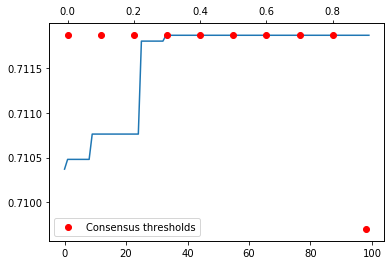

In [35]:
fig, ax1 = plt.subplots()
ax1.plot(x, label='Initial partitions')
#ax1.set_ylim(ylim)
ax2 = ax1.twiny()
ax2.scatter(df_modularities['threshold'], df_modularities['modularity'], color='red', label='Consensus thresholds')
plt.legend()
plt.show()